# CONTENT BASED MODELS

Imagine, we have a service (like Youtbe, Netflix or whatever) and we have some new users. We want to recommend our users something they would like, but those users are new, so we know nothing about them. How to build recommender system in such situation? Another question is how to score and recommend new items with known features but without known ratings. 

The answer is simple: we have items (videos, movies, ect). Each item has some features and each item has its own rating (calculated based on the grades users or critics put). We want to recommend items with higher rating to our newbies. Below there are three ways how to do that.

But firstly, let me show the datsets we are going to work with.

Download the preprocessed dataset [here](https://drive.google.com/drive/folders/1YPqWaZYW2axz91YKkaM7j_xPqF5rSVx2?usp=drive_link).

In [1]:
import os
import ast
import numpy as np
import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import norm as sparse_norm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Dataset

### Reviews


Lets have a look on our *reviews* dataset. In this dataset we need only four columns with titles *user_id*, *anime_id*, *favorites_anime* and *score*.

- ***user_id*** User profile name. Some profile names are literally insane =)

- ***anime_id*** The mapping of anime titles column onto integers.

- ***score*** grade, how the user with the specific *user_id* evaluated the anime with specific *anime_id*.

-  ***favorites_anime*** List of animes the user with the specific *user_id*  considered as his favourites. **ATTENTION** the animes from this list may not occur in user history (animes user graded). User may have mentioned some animes as favourites, but did not graded them. Automatically, we will consider that the score of favorite animes is **10**



In [2]:
USER_COL = "user_id"
ITEM_COL = "anime_id"
RELEVANCE_COL = "score"

In [3]:
base_path = "./anime_data"

In [4]:
review_data = pd.read_csv(os.path.join(base_path, 'reviews.gz'))

In [5]:
review_data.head()

,uid,user_id,anime_id,text,score,scores,link
0,255938,DesolatePsyche,34096,"First things first. My ""reviews"" system is exp...",8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,Let me start off by saying that Made in Abyss ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,"Art 9/10: It is great, especially the actions ...",7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,Story \r\ntaking place 1 yr from where season ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,Kyoto Animations greatest strength is being ab...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


#### Do you remember what is the difference between explicit and implicit feedback?

In [6]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print(f'Num reviews = {log.shape[0]},\nnum users = {log[user_id].nunique()},\nnum items = {log[item_id].nunique()}')

In [7]:
get_log_info(review_data, user_id=USER_COL, item_id=ITEM_COL)

Num reviews = 109297,
num users = 37458,
num items = 7636


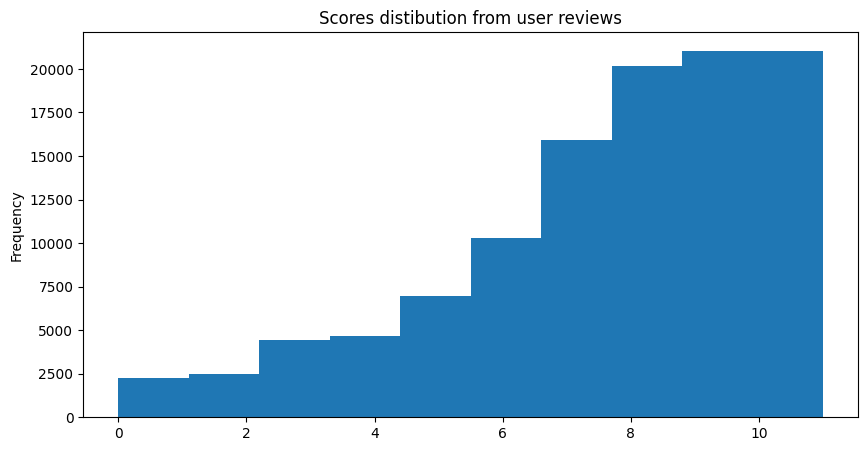

In [8]:
review_data[RELEVANCE_COL].plot.hist(bins=10, figsize=(10, 5), title='Scores distibution from user reviews');

#### How does the distribution of ratings change if we have, for example, a marketplace data?

In [9]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=20, figsize=(10, 5), title=title)
    return grouped

count    37458.000000
mean         2.917855
std          7.985410
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          3.000000
95%          9.000000
max        537.000000
Name: score, dtype: float64


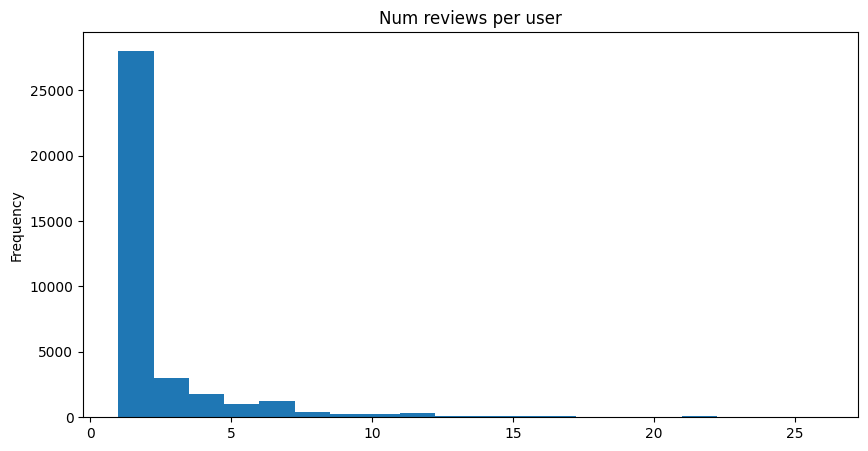

In [10]:
group_by_and_plot(review_data, group_by_name=USER_COL, rating_col_name=RELEVANCE_COL, quantile=0.99, title='Num reviews per user');

count    7636.000000
mean       14.313384
std        39.704994
min         1.000000
5%          1.000000
25%         1.000000
50%         3.000000
75%        11.000000
95%        59.000000
max      1080.000000
Name: score, dtype: float64


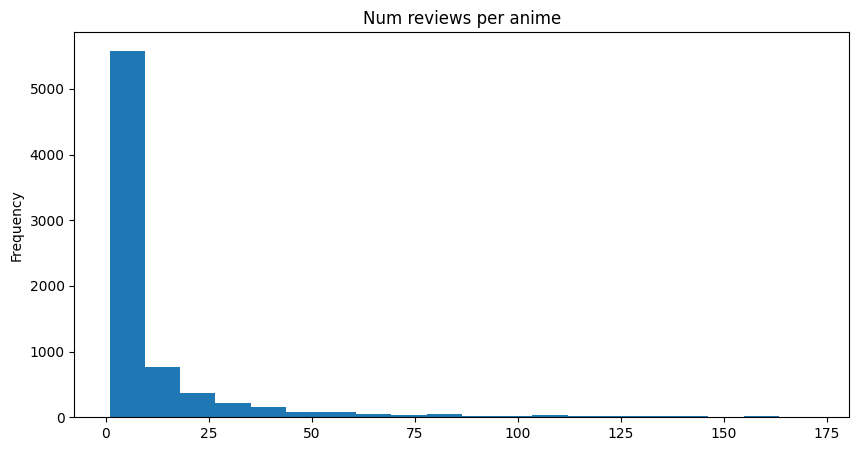

In [11]:
group_by_and_plot(review_data, group_by_name=ITEM_COL, rating_col_name=RELEVANCE_COL, quantile=0.99, title='Num reviews per anime');

#### How many animes could we reliably recommend using popularity-based methods? 

### Animes


The main columns for us are:

- ***anime_id*** - the same id we have in the table above.

- ***synopsis*** - the description of the anime with a specific **anime_id**

- ***score*** - average score over all the grades users or critics  put to the corresponding anime


In [12]:
anime_data = pd.read_csv(os.path.join(base_path, 'animes.gz'), na_filter=False)

In [13]:
anime_data.head(1).T

,0
anime_id,1
title,Cowboy Bebop
synopsis,"In the year 2071, humanity has colonized sever..."
genre,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
aired,"Apr 3, 1998 to Apr 24, 1999"
episodes,26
members,930311
popularity,39
ranked,26.0
score,8.81


In [14]:
anime_data['genre'].str.strip().str.split(", ").explode().value_counts()

genre
Comedy           5640
Action           3572
Fantasy          2971
Adventure        2753
Sci-Fi           2462
Kids             2458
Drama            2457
Shounen          1915
Music            1863
Romance          1762
Slice of Life    1744
School           1567
Supernatural     1358
Hentai           1295
Mecha            1060
Historical       1051
Magic            1013
Seinen            805
Ecchi             740
Sports            679
Mystery           674
Shoujo            668
Parody            619
Super Power       600
Military          541
Space             475
Demons            453
Horror            434
Dementia          402
Harem             374
Martial Arts      367
Game              348
Psychological     322
Police            239
Samurai           199
Vampire           135
Thriller          120
Cars              117
Josei              93
Shounen Ai         91
                   75
Shoujo Ai          73
Yuri               40
Yaoi               40
Name: count, dtype: int64

In [15]:
anime_data.shape # 7636 in reviews, the rest won't be covered by the popularity-based models

(16216, 12)

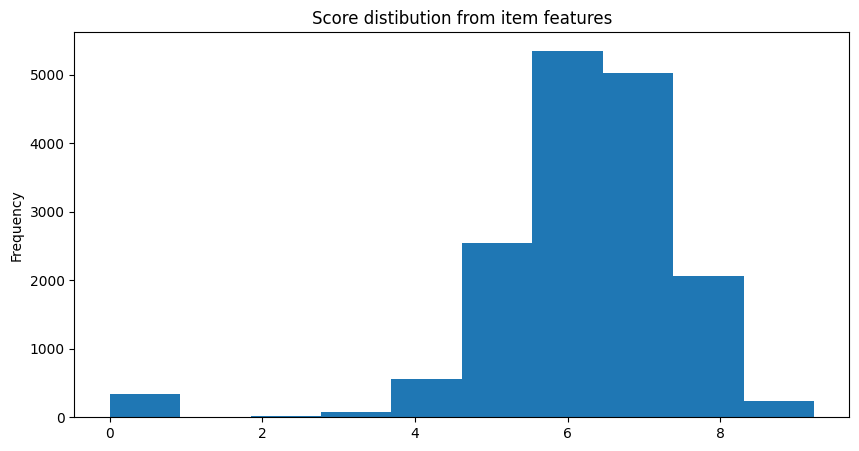

In [16]:
anime_data[RELEVANCE_COL].plot.hist(bins=10, title='Score distibution from item features', figsize=(10, 5));

In [17]:
(anime_data[RELEVANCE_COL] > 0).sum()

15875

In [18]:
all_anime_data = (
    anime_data[['anime_id', 'score']]
    .assign(tokens=anime_data[['title', 'genre', 'synopsis']].apply('; '.join, axis=1))
    .set_index('anime_id')
    # ['tokens']
)

In [19]:
all_anime_data.head()

,score,tokens
anime_id,,
1,8.81,"Cowboy Bebop; Action, Adventure, Comedy, Drama..."
5,8.40,"Cowboy Bebop: Tengoku no Tobira; Action, Drama..."
6,8.28,"Trigun; Action, Sci-Fi, Adventure, Comedy, Dra..."
7,7.32,"Witch Hunter Robin; Action, Magic, Police, Sup..."
8,7.02,"Bouken Ou Beet; Adventure, Fantasy, Shounen, S..."


#### What can we do with these tokens?

### User profiles

This dataset contains additional information about users, including their favorite anime.

- ***user_id*** - the same user id as in the reviews table.

- ***gender*** - user gender

- ***birthday*** - user birthday

- ***favorites_anime*** - a list of user favorites


In [20]:
profile_data = pd.read_csv(os.path.join(base_path, 'profiles.gz'), converters={'favorites_anime': ast.literal_eval})

In [21]:
profile_data.head()

,user_id,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","[226, 235, 269, 457, 1482, 1698, 2904, 4981, 5...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","[853, 918, 3588, 6956, 9253, 11061, 13601, 205...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"[512, 918, 1943, 2904, 9989, 11741, 17074, 232...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep 5,"[849, 2904, 3588, 5680, 37349]",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","[235, 849, 2167, 4181, 4382, 5680, 7791, 9617,...",https://myanimelist.net/profile/aManOfCulture99


In [22]:
profile_data.shape

(37458, 5)

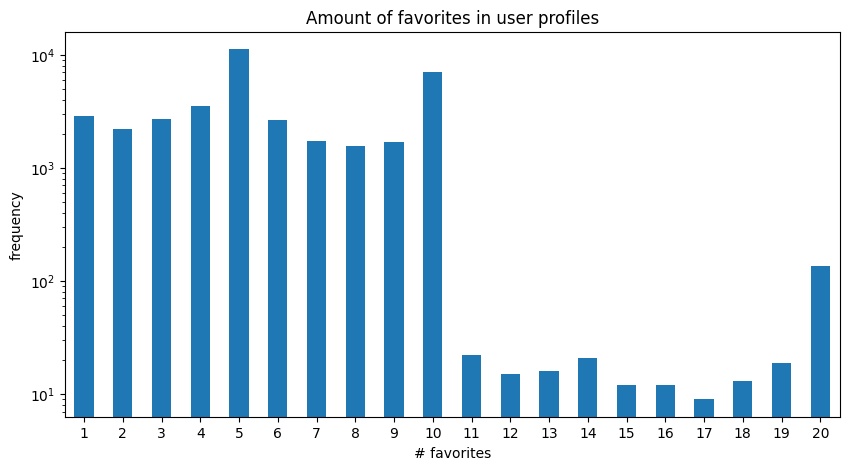

In [23]:
(
    profile_data['favorites_anime']
    .apply(len)
    .value_counts(sort=False).sort_index()#.cumsum()
    .plot.bar(
        logy=True,
        rot=0,
        xlabel='# favorites',
        ylabel='frequency',
        title='Amount of favorites in user profiles',
        figsize=(10, 5)
    )
);

### Favorites ratings

In [24]:
favorites_data = profile_data.set_index('user_id')['favorites_anime']
favorites_scores = pd.merge(
    favorites_data.explode().rename('anime_id').reset_index(),
    review_data[['user_id', 'anime_id', 'score']],
    on = ['user_id', 'anime_id'],
    how = 'left'
)['score']

print(f'Fraction of favorites without the rating: {favorites_scores.isnull().mean():.0%}')

Fraction of favorites without the rating: 93%


- Most of the favorites do not have ratings info.
- For the sake of evaluation in this excercise, we will make two assumptions:
  - favorites are of the highest interest to users,
  - other animes that users rate highly should be somewhat similar to their favorites.

# Data split


- In order to construct test set we use the users who have some anime in their favourites list.
- For these users we take **n_pairs** animes a user liked and **n_pairs** animes the user disliked from their anime reviews.
  - We assume the user liked anime if he put the grade no less than some *score_cutoff* value.
- The quality of predictions is then evaluated by comparing how close the liked animes to the favorites based on the predicted scores.

In [25]:
def get_test_pairs(reviews, favorites, n_pairs, score_cutoff, seed):
    '''
    Construct a dataset consisting of pairs of liked and disliked animes. The likes and dislikes
    are defined by the ratings value: everything below threshold is a dislike, the rest are likes.
        
    The function ensures that the amount of likes and dislikes is the same per each user in data.
    The users that do not contain enough likes or dislikes are discarded from the result.
    The result is to be used for evaluating the quality of recommendations by some algorithms.
    Hence, user favorites are excluded to ensure that there is no trivial solution.
    '''
    rng = np.random.default_rng(seed)
    def strict_sample_no_favs(series):
        # sample `n_pairs` elements from `series`, if not enough data - return empty list,
        # discard favorites, otherwise the evaluation on test pairs against favorites makes no sense
        above_cutoff, user_id = series.name
        allowed_items = np.setdiff1d(series.values, favorites.loc[user_id])
        return rng.choice(allowed_items, n_pairs, replace=False) if len(allowed_items)>=n_pairs else []
    
    test_pairs = (
        reviews
         # split by likes and dislikes, group by users
        .groupby([(reviews["score"] >= score_cutoff), 'user_id'])
        # sample `n_pairs` items (both likes and dislikes), disregard user favorites
        ['anime_id'].apply(strict_sample_no_favs)
         # disregard users that have not enough items
        .loc[lambda x: x.apply(len) > 0]
         # make two columns of likes and dislikes
        .unstack('score')
        # ensure each user has both likes and dislikes
        .dropna()
         # rename by
         # 
         # 
         #  rule `score >= score_cutoff`
        .rename(columns={False: 'dislikes', True: 'likes'})
    )
    return test_pairs

We will generate the training data by excluding animes from the pairs of likes and dislikes contained in the test data. 

In [26]:
def split_anime_train_test_data(reviews, favorites, anime, *, n_pairs=3, score_cutoff=5, seed=0):
    '''
    Function to construct train dataset. It deletes animes that occured in the test set
    to prevent information leakage from test to train.
    '''
    test_data = get_test_pairs(reviews, favorites, n_pairs, score_cutoff, seed)
    test_anime_set = (
        test_data
        .melt(value_name='animes') # reshape 2 columns into signle column
        ['animes'].explode() # flatten all lists into a single long 1d array
        .unique() # get only unique values
    )
    train_data = (
        anime
        # only use known score - to be used as the prediction target,
        # also prevent test data leaks into training
        .query('score > 0 and anime_id not in @test_anime_set')
        # combine several text fields into a unified feature view
        .assign(tokens = lambda x: x[['title', 'genre', 'synopsis']].apply('; '.join, axis=1))
        # only take necessary fields
        .loc[:, ['anime_id', 'tokens', 'score']]
    )
    return train_data, test_data

In [27]:
anime_train, anime_test = split_anime_train_test_data(
    review_data, favorites_data, anime_data, score_cutoff=5
)

In [28]:
anime_train.head()

,anime_id,tokens,score
1,5,"Cowboy Bebop: Tengoku no Tobira; Action, Drama...",8.40
4,8,"Bouken Ou Beet; Adventure, Fantasy, Shounen, S...",7.02
5,15,"Eyeshield 21; Action, Sports, Comedy, Shounen;...",8.02
7,17,"Hungry Heart: Wild Striker; Slice of Life, Com...",7.65
8,18,"Initial D Fourth Stage; Action, Cars, Sports, ...",8.18


In [29]:
# to evaluate classification/regression metrics

test_animes = (anime_test
        .melt(value_name='animes') # reshape 2 columns into signle column
        ['animes'].explode() # flatten all lists into a single long 1d array
        .unique()) # get only unique values

anime_test_animes = anime_data.query('score > 0 and anime_id in @test_animes') \
        .assign(tokens = lambda x: x[['title', 'genre', 'synopsis']].apply('; '.join, axis=1)) \
        .loc[:, ['anime_id', 'tokens', 'score']]

In [30]:
anime_data.query('score > 0').shape, anime_train.shape[0] + anime_test_animes.shape[0]

((15875, 12), 15875)

In [31]:
anime_test.head()

score,dislikes,likes
user_id,,
-Ereya-,"[6747, 169, 5525]","[12413, 15613, 9989]"
-HippySnob-,"[31245, 36516, 31804]","[16355, 39456, 37021]"
-Remix-,"[31043, 31914, 28171]","[29787, 15225, 11889]"
-Ryu,"[10620, 35849, 16762]","[36475, 401, 31904]"
0MAN0,"[17265, 226, 4382]","[15809, 10620, 849]"


In [32]:
anime_test_animes.head(2)

,anime_id,tokens,score
0,1,"Cowboy Bebop; Action, Adventure, Comedy, Drama...",8.81
2,6,"Trigun; Action, Sci-Fi, Adventure, Comedy, Dra...",8.28


In [33]:
anime_test.shape

(696, 2)

count    696.000000
mean      29.778736
std       43.207512
min        6.000000
5%         7.000000
25%       10.000000
50%       16.000000
75%       32.000000
95%       89.500000
max      537.000000
Name: anime_id, dtype: float64


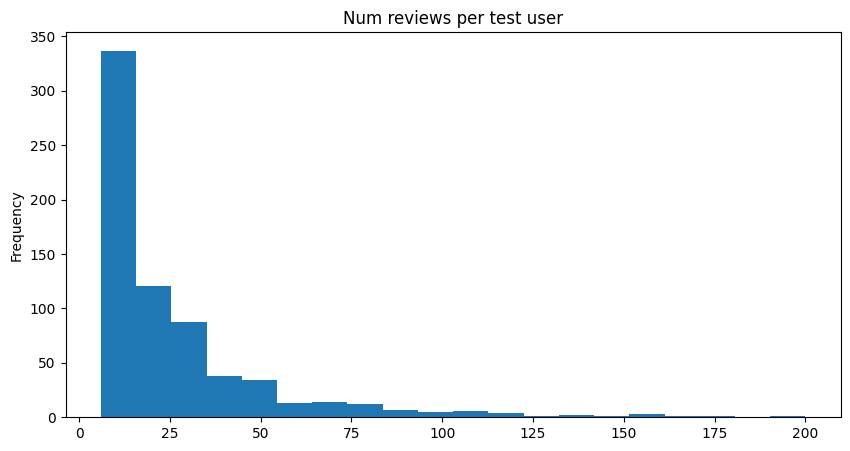

In [34]:
group_by_and_plot(review_data.query('user_id in @anime_test.index.values'), group_by_name=USER_COL, rating_col_name=ITEM_COL, quantile=0.99, title='Num reviews per test user');

You will need to build a personalized models for those users in your HW. Do you have enough data? 

In [35]:
favorites_data.head()

user_id
DesolatePsyche     [226, 235, 269, 457, 1482, 1698, 2904, 4981, 5...
baekbeans          [853, 918, 3588, 6956, 9253, 11061, 13601, 205...
skrn               [512, 918, 1943, 2904, 9989, 11741, 17074, 232...
edgewalker00                          [849, 2904, 3588, 5680, 37349]
aManOfCulture99    [235, 849, 2167, 4181, 4382, 5680, 7791, 9617,...
Name: favorites_anime, dtype: object

# Regression model

<!-- ## PURE CONTENT BASED MODELS

We will explore application of regression and classification approaches.
 -->
In regression task (in its straightforward implementation) we want to predict average score based on any parameter (parameters) of anime. Here we will use binary vectors of synopsis of each anime

$$
S = W * x +W_0
$$

where $x$ - text representation $S$ -predicted scores, $W_0$ -bias

In our case we need any representation of textual information. In first we will use a binary representation (if the word presents in text) and than will apply TFIDF representation.

## Task

Here we need to predict anime's rating. For this purpose we are going to use ***regression model***. The simplest regression model is ***Linear regression***.


$$
S = W * x +W_0
$$


Where **S** is predicted scores, **x** is our text representation and **W** is model weights

## Pipeline

Below you can see a simple pipeline for this task. Later we're going to extend it during our course.

- ***build_cb_model*** - this function constructs the model we need. As a rating predictor we use Linear regression.  The entries of this function is model config, trainset_description and trainset which we build above

- ***generate_features*** - applies CountVectorizer or TfidfVectorizer for items' descriptions
 
- ***cb_model_scoring*** - provides the scores for  the entry set of data. This function uses parameters which were defined in ***build_cb_model*** 

- ***cb_config*** - defines parameters of the model

- ***transform_predict*** - unified function to generate recommendations

- ***anime_description*** - maps names of features we use in ***build_cb_model***/***cb_model_scoring*** to column names, used for convenience.

In [37]:
class DenseTransformer(TransformerMixin):
    """
    Convert sparse matrix to dense np array to apply standard scaler with mean.
    """

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [38]:
def build_cb_model(config, trainset, trainset_description, logistic=False, binary_vectorizer=True):
    """
    Config and fit cb model
    """
    feature_matrix, word_vectorizer = generate_features(config, trainset, trainset_description, binary_vectorizer)
    if logistic:
        regressor = LogisticRegression
    elif 'alpha' in config['model']:
        regressor = Ridge
    else:
        regressor = LinearRegression
    target_column = trainset_description['feedback']
    model = regressor(**config['model']).fit(feature_matrix, trainset[target_column])
    return model, word_vectorizer

def generate_features(config, trainset, trainset_description, binary_vectorizer):
    """
    Config and fit text vectorizer
    """
    if binary_vectorizer:
        word_vectorizer = CountVectorizer(**config['vectorizer']['binary'])
    else:
        word_vectorizer = Pipeline([("tfidf", TfidfVectorizer(**config['vectorizer']['tfidf'])), 
                                    ('dense', DenseTransformer()), 
                                    ("scaler", StandardScaler())])
    features_column = trainset_description['item_features']
    feature_matrix = word_vectorizer.fit_transform(trainset[features_column])
    return feature_matrix, word_vectorizer


def transform_predict(params, tokens):
    """
    Get recommendations from either classification or regression model
    """
    model, word_vectorizer = params
    tokens_encoded = word_vectorizer.transform(tokens)
    try: # handle classification models
        predictor = model.predict_proba
    except AttributeError:
        predictor = model.predict
    scores = predictor(tokens_encoded)
    if scores.ndim > 1: # handle classification
        scores = scores[:, 1] # take class 1
    return scores

def cb_model_scoring(params, testset, testset_description):
    """
    Select necessary features and get recommendations with the fitted pipeline
    """
    tokens = testset[testset_description['item_features']]
    scores = transform_predict(params, tokens)
    return scores


## Linear regression with the binary text vectorization

In [127]:
cb_config = {
    "model": dict(),
    "vectorizer":{
        "binary": dict( # simple binary token encoder
            min_df = 5,
            max_df = 0.9,
            strip_accents='unicode',
            stop_words = 'english',
            analyzer = 'word',
            binary = True,
        ),
        "tfidf": dict( # TfIDF Vectorizer
            min_df = 5,
            max_df = 0.9,
            strip_accents='unicode',
            stop_words = 'english',
            analyzer = 'word',
            use_idf = True,
            smooth_idf = True,
            sublinear_tf = True,
            binary = False,
            norm="l2",
        ),
    }
}
# we also define a general representation of our dataset
anime_description = {
    'feedback' : "score",
    "item_features": "tokens",
}

In [40]:
reg_params = build_cb_model(cb_config, anime_train, anime_description)
reg_scores = cb_model_scoring(reg_params, anime_train, anime_description)
reg_scores_test_anime = cb_model_scoring(reg_params, anime_test_animes, anime_description)

In [41]:
reg_params[1]

CountVectorizer(binary=True, max_df=0.9, min_df=5, stop_words='english',
                strip_accents='unicode')

In [42]:
reg_params[0]

LinearRegression()

In [43]:
len(reg_params[1].vocabulary_), anime_train.shape[0]

(10571, 13791)

Any conserns?

In [44]:
len(reg_params[0].coef_), np.linalg.norm(reg_params[0].coef_)

(10571, 90.98839087490009)

In [45]:
reg_params[0].intercept_

5.795872748629343

#### TO DO: build a CountVectorizer + LinearRegression model without given functions, fit it with `anime_train` and get the scores for `anime_test_animes`.

In [ ]:
# YOUR CODE HERE

## Simple evaluation of our model

Here we compare predicted scores to the ground truth using MAE and RMSE metrics.



In [84]:
def calc_rmse_mae(predicted_scores, gt_scores):
    rmse = np.sqrt(np.mean((predicted_scores - gt_scores)**2))
    mae = np.mean(np.abs(predicted_scores - gt_scores))
    print(f'{rmse=:.4f}, {mae=:.4f}')

#### train scores

In [85]:
calc_rmse_mae(anime_train['score'].values, reg_scores)

rmse=0.3107, mae=0.2143


#### test scores

In [86]:
calc_rmse_mae(anime_test_animes['score'].values, reg_scores_test_anime)

rmse=3.5310, mae=2.6825


## A little bit of analysis

Let's look at the significant features of our model

In [87]:
def top_idx(a, topk):
    # idx of top-k with the biggest scores
    parted = np.argpartition(a, -topk)[-topk:]
    # idx of top-k sorted descending by relevance 
    return parted[np.argsort(-a[parted])]

In [88]:
def significant_features(params, topn=10, reverse=False):
    reg, word_vectorizer = params
    features_weights = reg.coef_.squeeze()
    if reverse:
        features_weights = -features_weights
    top_features_idx = top_idx(features_weights, topn)
    if isinstance(word_vectorizer, Pipeline):
        word_vectorizer = word_vectorizer[0]
    try: # handle API changes in different versions of sklearn
        features = word_vectorizer.get_feature_names()
    except AttributeError:
        features = word_vectorizer.get_feature_names_out()

    feature_scores = pd.DataFrame(
        zip(np.array(features)[top_features_idx], np.array(features_weights)[top_features_idx]),
        columns = ['feature', 'weight']
    )
    return feature_scores

### Linear regression feature importance

In [89]:
# features with the most positive impact
significant_features(reg_params)

,feature,weight
0,ryougi,10.479061
1,uncanny,5.399961
2,gunsou,5.296858
3,reinhard,5.115094
4,regime,5.088117
5,literal,4.789931
6,html,4.770608
7,endlessly,4.742725
8,penelope,4.661494
9,manipulated,4.284525


In [90]:
# features with the most negative impact
significant_features(reg_params, reverse=True)

,feature,weight
0,kokutou,6.699369
1,musel,6.410291
2,furinkan,5.277603
3,overwhelm,5.147471
4,mikiya,5.046363
5,intensified,4.835792
6,keroro,4.699940
7,inhuman,4.655005
8,ukkari,4.551105
9,aozaki,4.520563


In [91]:
the_anime_name = "Kara no Kyoukai"
the_anime_series = anime_data[anime_data['title'].str.contains(the_anime_name)].anime_id.unique()
the_anime_reviews = review_data[(review_data['anime_id'].isin(the_anime_series))].copy()
the_anime_reviews.loc[:, 'text'] = the_anime_reviews['text'].str.lower()
ryougi = the_anime_reviews[the_anime_reviews['text'].str.contains("ryougi")].shape[0]
kokutou = the_anime_reviews[the_anime_reviews['text'].str.contains("kokutou")].shape[0]
both = the_anime_reviews[(the_anime_reviews['text'].str.contains("kokutou")) 
       & (the_anime_reviews['text'].str.contains("ryougi"))].shape[0]

In [92]:
print(f"Num reviews for {the_anime_name} with {ryougi = } with {kokutou = }, with {both = }")

Num reviews for Kara no Kyoukai with ryougi = 28 with kokutou = 24, with both = 13


Also gunsou (2-nd positive) keroro (6-th negative) is a name of an anime.

#### What could be the reason? 

## Ridge regression with the binary text vectorization

In [93]:
cb_config["model"] = {"alpha": 100}

In [94]:
ridge_reg_params = build_cb_model(cb_config, anime_train, anime_description)
ridge_reg_scores = cb_model_scoring(ridge_reg_params, anime_train, anime_description)
ridge_reg_scores_test_anime = cb_model_scoring(ridge_reg_params, anime_test_animes, anime_description)

In [95]:
ridge_reg_params[1]

CountVectorizer(binary=True, max_df=0.9, min_df=5, stop_words='english',
                strip_accents='unicode')

In [96]:
ridge_reg_params[0]

Ridge(alpha=100)

In [97]:
np.linalg.norm(ridge_reg_params[0].coef_)

2.900354550059406

In [98]:
ridge_reg_params[0].intercept_

5.747807261296664

#### train scores

In [99]:
calc_rmse_mae(anime_train['score'].values, ridge_reg_scores)

rmse=0.6332, mae=0.4866


#### test scores

In [100]:
calc_rmse_mae(anime_test_animes['score'].values, ridge_reg_scores_test_anime)

rmse=0.8467, mae=0.6509


### Ridge regression feature importance

In [101]:
# features with the most positive impact
significant_features(ridge_reg_params)

,feature,weight
0,shounen,0.319995
1,educational,0.299922
2,drama,0.291169
3,mystery,0.262992
4,seinen,0.256544
5,written,0.236287
6,safety,0.227829
7,hen,0.192995
8,shoujo,0.190023
9,romance,0.189459


In [102]:
# features with the most negative impact
significant_features(ridge_reg_params, reverse=True)

,feature,weight
0,dementia,0.515811
1,korean,0.290742
2,horror,0.194687
3,zhu,0.193724
4,commercial,0.182028
5,collaboration,0.180758
6,peeping,0.172743
7,xia,0.172308
8,music,0.161226
9,prefecture,0.158309


#### Think, does it make sense to use this kind of analysis of significant features in the case of non-binary feature matrix?

#### scores distribution

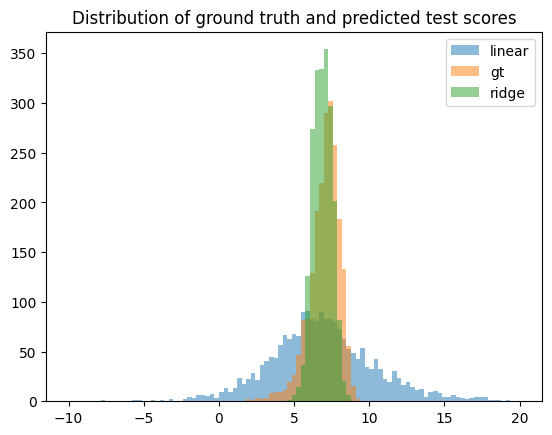

In [103]:
bins = np.linspace(-10, 20, 100)
plt.hist(reg_scores_test_anime, bins=bins, alpha=0.5, label='linear');
plt.hist(anime_test_animes['score'].values, bins=bins, alpha=0.5, label='gt');
plt.hist(ridge_reg_scores_test_anime, bins=bins, alpha=0.5, label='ridge');

plt.title("Distribution of ground truth and predicted test scores")
plt.legend(loc='upper right')
plt.show()

**Remark** 

Do not forget to regularize your models)

During the cource we will move from content-based models to the models, build on top os users interactions with the items. Items could also be pretty similar and appear in groups, leading to multicollinearity. Regularization will appear as one of the important success factors for collaborative filtering models.

## EVALUATION

Imagine, we don't have exact anime rating. How to understand whether our model is sane or not? Let's refresh all the info we have for users $u\in\mathcal{U}$.

For each user we have:
- predicted scores $r_i$ for a user $u$ likes ($i\in\mathcal{I}_u^+$)
- predicted scores $r_j$ for a user $u$ dislikes ($j\in\mathcal{I}_u^-$)
- predicted scores $r_k$ for user favourites ($k\in\mathcal{I}_u^f$)

By construction, the set of user favorites is disjoint from the items in the test user preferences $(\mathcal{I}_u^+ \cup \mathcal{I}_u^-)\cap\mathcal{I}_u^f=\emptyset$   (see `get_test_pairs` function).

Intuitively, the predicted scores on a user's favourite animes should be (on average) closer to the predicted scores on the user's likes rather than on dislikes. So, the evaluation is based on the following "closeness-rate" metric:
$$
CR = \frac{1}{|\mathcal{U}|}\sum_{u\in\mathcal{U}}\frac{1}{|\mathcal{I^f_u}|}\sum_{k\in\mathcal{I}_u^f}\mathbb{I}\left(\text{dist}(k,\mathcal{I_u^+})<\text{dist}(k,\mathcal{I_u^-})\right),
$$
where $\mathbb{I}(\cdot)$ is an indicator function that returns 1 or 0 depending on whether its argument is true or not. The distances can be mesured, for example, simply as
$$
\text{dist}(k,\mathcal{I_u^+}) = \frac{1}{|\mathcal{I_u^+}|}{\sum_{i\in\mathcal{I_u^+}}(r_i - r_k)^2}, \\
\text{dist}(k,\mathcal{I_u^-}) = \frac{1}{|\mathcal{I_u^-}|}\sum_{j\in\mathcal{I_{u}^-}}{(r_j - r_k)^2}.
$$

In short, *the deviation of the predicted scores on favorite items from the predcited scores of liked items must be lower then that of the disliked items*. Note that in our setup $|\mathcal{I}_u^+|=|\mathcal{I}_u^-|=n\_pairs$.

Think of other possible functions for the distance estimation.


In [104]:
def cb_model_evaluation(params, test_pairs, favorites, anime_features, distance_function):
    positive_is_closer = []
    for user_id, likes, dislikes in test_pairs[['likes', 'dislikes']].itertuples(name=None):
        pos_distance, neg_distance = distance_function(user_id, likes, dislikes, params, favorites, anime_features)
        positive_is_closer.append((pos_distance < neg_distance).mean())
    return np.mean(positive_is_closer)


def cb_distances(user_id, likes, dislikes, params, favorites, anime_features):
    """
    Caclulate the distance between user's favorites and likes, 
    as well as between user's favorites and dislikes based on scores of a regression model
    """
    user_favorites = favorites[user_id]
    # (n_positives,)
    scores_pos = transform_predict(params, anime_features.loc[likes, 'tokens'])
    scores_neg = transform_predict(params, anime_features.loc[dislikes, 'tokens'])
    # (n_favorites,)
    scores_fav = transform_predict(params, anime_features.loc[user_favorites, 'tokens'])
    # (n_positives, n_favorites) -> (n_favorites), mean distance between the favorite and all users' positives
    pos_deviation = np.power(np.subtract.outer(scores_pos, scores_fav), 2).mean(axis=0)
    neg_deviation = np.power(np.subtract.outer(scores_neg, scores_fav), 2).mean(axis=0)
    return pos_deviation,neg_deviation

In [105]:
cb_model_evaluation(reg_params, anime_test, favorites_data, all_anime_data, cb_distances)

0.4507185417270356

In [106]:
cb_model_evaluation(ridge_reg_params, anime_test, favorites_data, all_anime_data, cb_distances)

0.5661421273490238

Is this result good or bad? Let's compare it to the random prediction.

## Random prediction baseline

In [107]:
class RandomPredictor:
    def __init__(self, seed):
        self.rng = np.random.default_rng(seed)

    def predict(self, tokens_encoded):
        return self.rng.standard_normal(tokens_encoded.shape[0])

In [108]:
rnd_res = []
n_tries = 5
for seed in np.random.SeedSequence().generate_state(n_tries):
    rnd_params = (RandomPredictor(seed), reg_params[1])
    rnd_res.append(cb_model_evaluation(rnd_params, anime_test, favorites_data, all_anime_data, cb_distances))

print(f'Random model result: {np.mean(rnd_res):.4f}+-{np.std(rnd_res):.4f}')

Random model result: 0.4971+-0.0145


## Ridge regression with the TF-IDF text representation

### TFIDF

According the wikipedia TFIDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We wll use TFIDF for this purpose.




TFIDF constructs the representation of the text as a multiplication of two statistics : 

- ***Term frequency***, wich shows how many times a specific word (term) $t$ happens in the document (synopsis in our case) $d$

$$tf (t,f) = \frac{f(t,d)}{\sum_{t' \in d}{f(t',d)}}$$


- ***Inverse document frequency*** shows how common or rare the word (term) across all documents.

$$idf(t, D) = \log{\frac{|D|}{|d \in D; t\in d |}}$$


So the resulting metric is just a multiplication of $tf$ and $idf$. This metrics automatically provides more attention to the words that are more important for document claclassification.

### "alpha": 10

In [128]:
cb_config["model"] = {"alpha": 10}

In [129]:
%%time
tfidf_reg_params = build_cb_model(cb_config, anime_train, anime_description, binary_vectorizer=False)
tfidf_reg_scores = cb_model_scoring(tfidf_reg_params, anime_train, anime_description)
tfidf_reg_scores_test_anime = cb_model_scoring(tfidf_reg_params, anime_test_animes, anime_description)

CPU times: user 1min 15s, sys: 11.8 s, total: 1min 27s
Wall time: 36.1 s


In [130]:
tfidf_reg_params[1]

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english',
                                 strip_accents='unicode', sublinear_tf=True)),
                ('dense', <__main__.DenseTransformer object at 0x1341ef1f0>),
                ('scaler', StandardScaler())])

In [131]:
tfidf_reg_params[0]

Ridge(alpha=10)

In [140]:
# sublinear TF causes negative scores
np.min(tfidf_reg_params[1].transform(anime_test_animes['tokens'])), np.max(tfidf_reg_params[1].transform(anime_test_animes['tokens']))

(-0.7139781526638164, 166.79069277810825)

In [141]:
len(tfidf_reg_params[0].coef_), np.linalg.norm(tfidf_reg_params[0].coef_)

(10571, 1.6105880952955995)

In [142]:
tfidf_reg_params[0].intercept_

6.2428185048219875

#### train scores

In [143]:
calc_rmse_mae(anime_train['score'].values, tfidf_reg_scores)

rmse=0.3022, mae=0.2219


#### test scores

In [144]:
calc_rmse_mae(anime_test_animes['score'].values, tfidf_reg_scores_test_anime)

rmse=1.9960, mae=1.5658


#### Ridge regression feature importance with TFIDF

In [145]:
# features with the most positive impact
significant_features(tfidf_reg_params)

,feature,weight
0,rantarou,0.151859
1,symphogear,0.133631
2,ryougi,0.106210
3,arts,0.092314
4,fi,0.090388
5,lagann,0.089279
6,cofun,0.074564
7,bramble,0.071056
8,keiichi,0.068374
9,taku,0.064839


In [146]:
# features with the most negative impact
significant_features(tfidf_reg_params, reverse=True)

,feature,weight
0,nintama,0.135022
1,zesshou,0.112227
2,furukawa,0.083272
3,tanaami,0.079853
4,coffy,0.078917
5,briar,0.077880
6,martial,0.076273
7,kameari,0.076246
8,sci,0.072962
9,zhu,0.070020


In [147]:
cb_model_evaluation(tfidf_reg_params, anime_test, favorites_data, all_anime_data, cb_distances)

0.5012938778785635

### "alpha": 20000

In [148]:
cb_config["model"] = {"alpha": 20000}

In [149]:
%%time
tfidf_reg_params = build_cb_model(cb_config, anime_train, anime_description, binary_vectorizer=False)
tfidf_reg_scores = cb_model_scoring(tfidf_reg_params, anime_train, anime_description)
tfidf_reg_scores_test_anime = cb_model_scoring(tfidf_reg_params, anime_test_animes, anime_description)

CPU times: user 1min 31s, sys: 13.6 s, total: 1min 45s
Wall time: 45.9 s


In [150]:
tfidf_reg_params[1]

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english',
                                 strip_accents='unicode', sublinear_tf=True)),
                ('dense', <__main__.DenseTransformer object at 0x136a941f0>),
                ('scaler', StandardScaler())])

In [151]:
tfidf_reg_params[0]

Ridge(alpha=20000)

In [92]:
np.max(tfidf_reg_params[1].transform(anime_test_animes['tokens']), axis=0)

array([ 4.14554288e+01,  3.66008830e+01,  2.54790056e+01, ...,
       -2.38940715e-02,  2.86276069e+01,  4.75399038e+01])

In [93]:
len(tfidf_reg_params[0].coef_), np.linalg.norm(tfidf_reg_params[0].coef_)

(10571, 0.29993991347422755)

In [94]:
tfidf_reg_params[0].intercept_

6.242818504821986

#### train scores

In [153]:
calc_rmse_mae(anime_train['score'].values, tfidf_reg_scores)

rmse=0.5441, mae=0.4183


#### test scores

In [154]:
calc_rmse_mae(anime_test_animes['score'].values, tfidf_reg_scores_test_anime)

rmse=0.9044, mae=0.7091


#### Ridge regression feature importance with TFIDF

In [155]:
# features with the most positive impact
significant_features(tfidf_reg_params)

,feature,weight
0,drama,0.026387
1,shounen,0.024378
2,rewrite,0.024182
3,romance,0.024128
4,written,0.023338
5,mal,0.021433
6,school,0.019090
7,mystery,0.017683
8,gintama,0.017345
9,fantasy,0.016858


In [156]:
# features with the most negative impact
significant_features(tfidf_reg_params, reverse=True)

,feature,weight
0,dementia,0.037829
1,music,0.028015
2,short,0.021413
3,song,0.019825
4,zhu,0.016772
5,korean,0.016440
6,kids,0.016178
7,video,0.016035
8,uta,0.014291
9,tanaami,0.014044


In [157]:
cb_model_evaluation(tfidf_reg_params, anime_test, favorites_data, all_anime_data, cb_distances)

0.5346310909856803

### Shap values for Ridge regression with TFIDF

In [159]:
anime_train.head(2)

,anime_id,tokens,score
1,5,"Cowboy Bebop: Tengoku no Tobira; Action, Drama...",8.40
4,8,"Bouken Ou Beet; Adventure, Fantasy, Shounen, S...",7.02


In [171]:
cb_config["model"] = {"alpha": 10}

In [172]:
tf_idf = TfidfVectorizer(**cb_config["vectorizer"]["tfidf"])

In [173]:
train_vectorized = tf_idf.fit_transform(anime_train["tokens"]).toarray()

In [174]:
ridge_tf_idf = Ridge(**cb_config["model"])

In [175]:
ridge_tf_idf.fit(train_vectorized, anime_train["score"])

Ridge(alpha=10)

In [176]:
tf_idf.vocabulary_["music"]

6122

In [177]:
train_preds_tf_idf = ridge_tf_idf.predict(train_vectorized)

In [178]:
# explain the model's predictions using SHAP
explainer = shap.explainers.Linear(ridge_tf_idf, train_vectorized)
shap_values = explainer(train_vectorized)

In [179]:
# we add back the feature names stripped by the TfidfVectorizer
for word,idx in tf_idf.vocabulary_.items():
    shap_values.feature_names[idx] = word

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


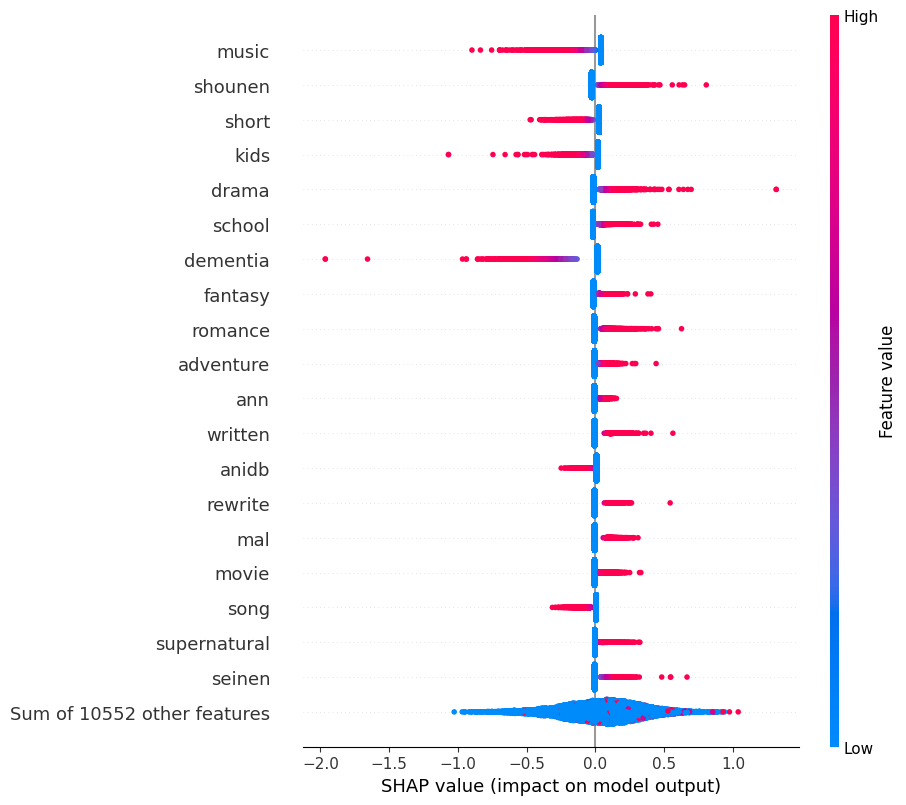

In [180]:
shap.plots.beeswarm(shap_values, max_display=20)

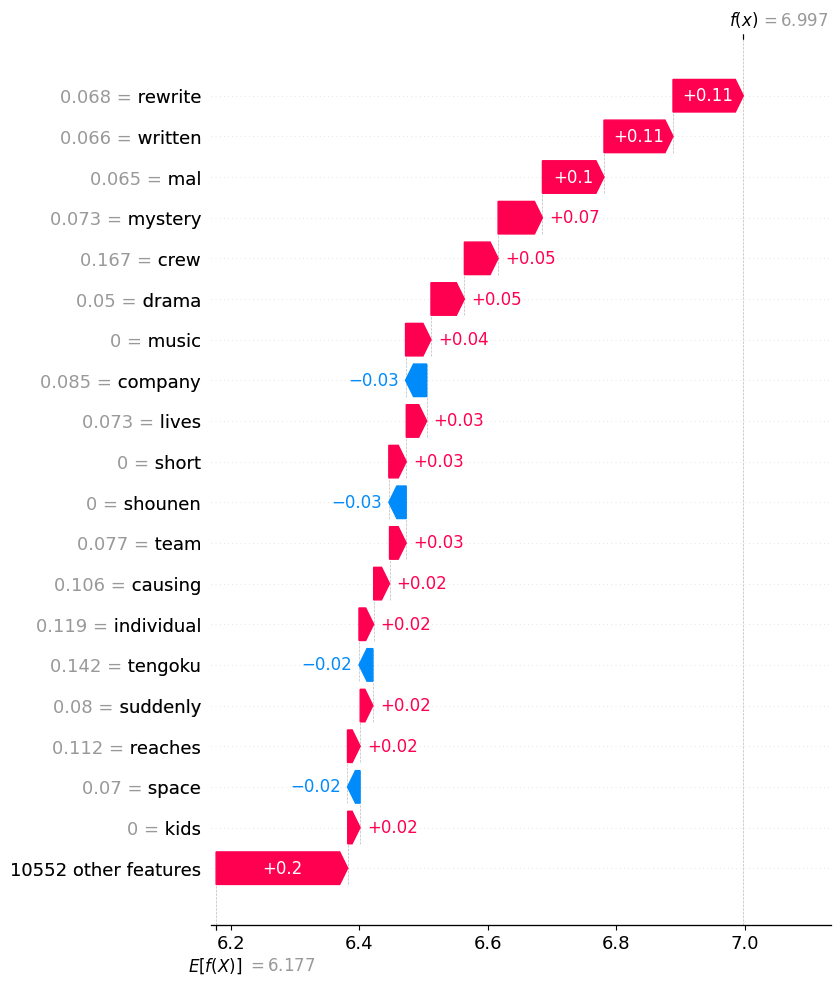

In [181]:
shap.plots.waterfall(shap_values[0], max_display=20)

# Classification Task

- Your task is to turn regression model into classification model.
- Use `LogisitcRegression` class from `sklearn` fro this.
- adopt previously derived functions for the new approach.

- try using more than 2 classes (i.e., not just binary)

In classification task we predict any category (label). Here we will predict whether the  anime can be recommended or not. We will do it in simple way. For example LogReg


$$
y_{pred} = \frac{1}{1+e^{W*x +W_0}}
$$

But first of all we need to label our dataset. Let's take a look at the scores

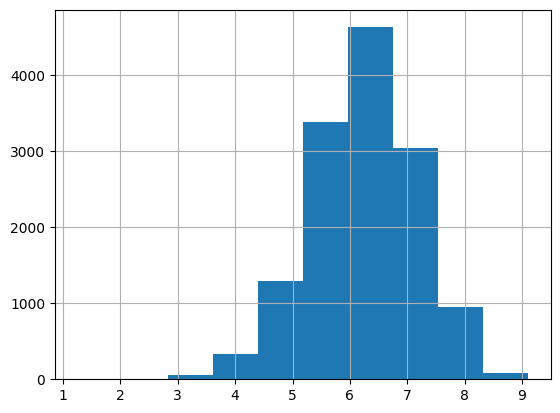

In [183]:
anime_train.query('score>0').score.hist(bins=10);

In [184]:
anime_train.query('score>0').score.mean()

6.242818504821985

The histogram shows that the mean of our average score distribution is a little bit disolased.
So we can take its mean as a borderline and say, that all the animes with average score < 6.24 are lame,  and all the animes with scores above this value are lit

#### What kind of interactions data could we get and how could we transform the target to get binary targets?

In [187]:
def assign_labels(data, cutoff):
    '''Add the binary `recommend` field based on the score cutoff value'''
    labeled_df = data.assign(
        recommend = lambda x: x['score'].ge(cutoff).astype(int)
    )
    return labeled_df

### Logistic regression with binary features

In [188]:
cb_config["model"] = {"C": 0.1, 
                      "max_iter": 1000, 
                      "class_weight": "balanced"
                     }

In [190]:
score_cutoff = 6.24

gt_label = assign_labels(anime_train, score_cutoff)
gt_label["recommend"].mean()

0.5217170618519325

In [191]:
logreg_params = build_cb_model(
    cb_config,
    # extend dataset with class labels
    gt_label,
     # target 0/1 instead of raw scores
    {**anime_description, **{'feedback': 'recommend'}},
    # use logistic regression instead of LR 
    logistic = True,
    binary_vectorizer = True
)

In [192]:
logreg_params[1]

CountVectorizer(binary=True, max_df=0.9, min_df=5, stop_words='english',
                strip_accents='unicode')

In [193]:
logreg_params[0]

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

In [194]:
logreg_scores = cb_model_scoring(logreg_params, anime_train, anime_description)
logreg_scores_test_anime = cb_model_scoring(logreg_params, anime_test_animes, anime_description)

In [195]:
(logreg_scores_test_anime >= 0.5).astype(int).mean()

0.8397312859884837

In [196]:
accuracy_score(y_true=assign_labels(anime_train, score_cutoff)['recommend'], y_pred=(logreg_scores >= 0.5).astype(int))

0.8354724095424553

In [197]:
accuracy_score(y_true=assign_labels(anime_test_animes, score_cutoff)['recommend'], y_pred=(logreg_scores_test_anime >= 0.5).astype(int))

0.8166986564299424

In [198]:
cb_model_evaluation(logreg_params, anime_test, favorites_data, all_anime_data, cb_distances)

0.5631352523593903

#### Logistic regression feature importance

In [199]:
# features with the most positive impact
significant_features(logreg_params)

,feature,weight
0,shounen,0.829396
1,pokemon,0.822931
2,drama,0.733493
3,educational,0.726445
4,doraemon,0.713337
5,mystery,0.697984
6,seinen,0.689838
7,idolish7,0.667570
8,safety,0.650247
9,harem,0.646360


In [200]:
# features with the most negative impact
significant_features(logreg_params, reverse=True)

,feature,weight
0,dementia,1.081195
1,korean,0.887100
2,commercial,0.645749
3,peeping,0.642091
4,era,0.600385
5,promoting,0.598940
6,prefecture,0.557101
7,horror,0.547055
8,duel,0.541816
9,promotional,0.519528


### Logistic regression with TFIDF features

In [201]:
cb_config["model"] = {"C": 0.0001, 
                      "max_iter": 1000, 
                      "class_weight": "balanced"
                     }

In [202]:
logreg_params = build_cb_model(
    cb_config,
    # extend dataset with class labels
    gt_label,
     # target 0/1 instead of raw scores
    {**anime_description, **{'feedback': 'recommend'}},
    # use logistic regression instead of LR 
    logistic = True,
    binary_vectorizer = False
)

In [203]:
logreg_params[1]

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english',
                                 strip_accents='unicode', sublinear_tf=True)),
                ('dense', <__main__.DenseTransformer object at 0x13975fe80>),
                ('scaler', StandardScaler())])

In [204]:
logreg_params[0]

LogisticRegression(C=0.0001, class_weight='balanced', max_iter=1000)

In [205]:
logreg_scores = cb_model_scoring(logreg_params, anime_train, anime_description)
logreg_scores_test_anime = cb_model_scoring(logreg_params, anime_test_animes, anime_description)

In [206]:
cb_model_evaluation(logreg_params, anime_test, favorites_data, all_anime_data, cb_distances)

0.5441399744328244

#### Logistic regression feature importance

In [207]:
# features with the most positive impact
significant_features(logreg_params)

,feature,weight
0,romance,0.039710
1,drama,0.039530
2,shounen,0.039207
3,school,0.034366
4,rewrite,0.033157
5,written,0.032244
6,mal,0.029859
7,mystery,0.024898
8,adventure,0.024843
9,doraemon,0.024455


In [208]:
# features with the most negative impact
significant_features(logreg_params, reverse=True)

,feature,weight
0,music,0.047537
1,song,0.038225
2,dementia,0.037928
3,video,0.037832
4,kids,0.026110
5,short,0.025834
6,uta,0.022615
7,anidb,0.021844
8,official,0.020216
9,minna,0.020167


# Content-based similarity models

We will build so called ***user profile***  - the weighted vector of user's preferences. This way, user represented as a vector of consolidated item features. 

### User profile construction

Assuming we have a user $u$, who gave ratings $r_i$ to each anime $i\in\mathcal{I_u}$, represented by feature vector $a_i$,  the corresponding user feature profile vector is then defined as:

$$
v_{\mathcal{I}_u} = \frac{\sum_{i\in\mathcal{I_u}} (r_i \cdot a_{i})}{\sum_{i\in\mathcal{I_u}} r_i}
$$

In order to provide recommendations for the specific user we are going to compare an anime vector representation to user profile vector, which will indicate how close this anime to user preferences from $\mathcal{I_u}$.

#### What are the other ways to construct a user profile? What could a the problem in the above formula?

### The model

In [209]:
def build_sim_model(config, trainset, trainset_description, binary_vectorizer=True):
    _, word_vectorizer = generate_features(config, trainset, trainset_description, binary_vectorizer)
    return None, word_vectorizer

In [210]:
sim_config = {
    'vectorizer': cb_config['vectorizer'].copy()
}

In [211]:
sim_params = build_sim_model(sim_config, anime_train, anime_description)

In [212]:
sim_params

(None,
 CountVectorizer(binary=True, max_df=0.9, min_df=5, stop_words='english',
                 strip_accents='unicode'))

### Evaluation

For the evaluation purpose we are going to measure distances between vector representation of user's favourites and the user's likes and dislikes. We assume that cosine similarity of 1st pair of vectors is greater than cosine similarity of 2nd pair of vectors. Accordingly, the distance functions in the evaluation of CR metric can be set as:
$$
\text{dist}(k,\mathcal{I_u^+}) = 1-\text{sim}(v_{\mathcal{I}_u^+}, v_k), \\
\text{dist}(k,\mathcal{I_u^-}) = 1-\text{sim}(v_{\mathcal{I}_u^-}, v_k),
$$
where $v_{I_u^+}$ and $v_{I_u^-}$ are user feature profiles (consolidated based on features of liked and disliked items) and $v_k$ is a favorite item feature vector.

#### Is cosine similarity better than dot product? What is be the difference?

In [213]:
def sim_distances(user_id, likes, dislikes, params, favorites, anime_features):
    """
    Caclulate the distance between user's favorites and likes, 
    as well as between user's favorites and dislikes based on scores of a content-based similarity model
    """
    _, word_vectorizer = params
    # get favorite items features representation
    # (n_favorites, vocabulary size)
    favorites_features = word_vectorizer.transform(anime_features.loc[favorites[user_id], 'tokens'].values)
    # get user representation
    user_profile_pos = generate_feature_profile(likes, word_vectorizer, anime_features)
    # calculate distance from liked items to favorites
    similarity_pos = feature_similarity(favorites_features, user_profile_pos)
    # calculate distance from disliked items to favorites
    user_profile_neg = generate_feature_profile(dislikes, word_vectorizer, anime_features)
    similarity_neg = feature_similarity(favorites_features, user_profile_neg)
    return 1-similarity_pos, 1-similarity_neg
        
def generate_feature_profile(items, word_vectorizer, item_features):
    """
    Feature profile of a user
    """
    scores = item_features.loc[items, 'score'].values
    tokens = item_features.loc[items, 'tokens'].values
    # (n_items, vocabulary size)
    feature_matrix = word_vectorizer.transform(tokens)
    # (n_items,)
    weights = scores / np.sum(scores)
    # (vocabulary size, )
    return feature_matrix.T.dot(weights)

def feature_similarity(feature_matrix, feature_profile):
    """
    Caclulate the similarity between user's favorites and likes/dislikes, 
    based on content-based cosine similarity
    """
    # (n_favorites, vocabulary size) @ (vocabulary size)
    similarity = feature_matrix.dot(feature_profile)
    weights = sparse_norm(feature_matrix, axis=1) * np.linalg.norm(feature_profile)
    similarity /= weights
    return similarity

In [214]:
cb_model_evaluation(sim_params, anime_test, favorites_data, all_anime_data, sim_distances)

0.5676271233414996

#### TO DO: get the recommendation to the user by building the user's vector from his positives and finding the closest items

In [215]:
the_user_positives  = anime_test.loc["King_Of_Light", :]["likes"]
the_user_positives

array([13759, 28817, 18679])

In [217]:
anime_data.query("anime_id in @the_user_positives")[["anime_id", "title", "synopsis", "genre"]]

,anime_id,title,synopsis,genre
6991,13759,Sakura-sou no Pet na Kanojo,When abandoned kittens and his good conscience...,"Slice of Life, Comedy, Drama, Romance, School"
7891,18679,Kill la Kill,"After the murder of her father, Ryuuko Matoi h...","Action, Comedy, Super Power, Ecchi, School"
9813,28817,Mikagura Gakuen Kumikyoku (TV),To be around cute girls wearing cute clothing ...,"Action, Comedy, School, Shoujo Ai"


In [220]:
all_anime_data["tokens"].head(2)

anime_id
1    Cowboy Bebop; Action, Adventure, Comedy, Drama...
5    Cowboy Bebop: Tengoku no Tobira; Action, Drama...
Name: tokens, dtype: object

In [218]:
# anime_data['anime_id'] == all_anime_data.index

In [1]:
# Construct the user's vector
# user_vector = 

In [221]:
full_item_feature_matrix = sim_params[1].transform(all_anime_data["tokens"])
full_item_feature_matrix

<16216x10571 sparse matrix of type '<class 'numpy.int64'>'
	with 494862 stored elements in Compressed Sparse Row format>

In [3]:
weights = sparse_norm(full_item_feature_matrix, axis=1) * np.linalg.norm(user_vector)
weights

In [4]:
# get the scores
# scores = 

In [225]:
the_user_pred = top_idx(scores, topk=10)


pd.DataFrame({"anime_idx": the_user_pred, "score": scores[the_user_pred]}).merge(anime_data[["anime_id", "title", "synopsis", "genre"]], left_on="anime_idx", right_index=True)

,anime_idx,score,anime_id,title,synopsis,genre
0,6991,0.709211,13759,Sakura-sou no Pet na Kanojo,When abandoned kittens and his good conscience...,"Slice of Life, Comedy, Drama, Romance, School"
1,7891,0.647430,18679,Kill la Kill,"After the murder of her father, Ryuuko Matoi h...","Action, Comedy, Super Power, Ecchi, School"
2,9813,0.581300,28817,Mikagura Gakuen Kumikyoku (TV),To be around cute girls wearing cute clothing ...,"Action, Comedy, School, Shoujo Ai"
3,10876,0.283980,31439,Wagamama High Spec,The adorable girls of Ousui Academy's student ...,"Comedy, School"
4,10421,0.278473,30355,Wakaba*Girl,"Wakaba Kohashi, a sheltered rich girl, dreams ...","Comedy, School, Slice of Life"
5,8442,0.273352,21635,GJ-bu@,"During the school's spring break, Kyouya ""Kyor...","Comedy, School, Slice of Life"
6,54,0.268745,74,Gakuen Alice,Mikan Sakura is a normal 10-year-old girl. Opt...,"Comedy, School, Shoujo, Super Power"
7,6916,0.267355,13367,"Kono Naka ni Hitori, Imouto ga Iru!","Shougo Mikadono's father has just passed away,...","Comedy, Ecchi, Harem, Mystery, Romance, School"
8,14729,0.262539,38295,Joshikausei,Momoko Futo is an average high-school girl goi...,"Comedy, School, Slice of Life"
9,15583,0.261950,39570,High Score Girl II,"The year is 1996, and second-year high school ...","Comedy, Game, Romance, School, Seinen"


#### Is this evaluation by favorite genres completly fair? 